In [1]:
#ラベリングによる学習/検証データの準備
from PIL import Image
import os, glob
import numpy as np
import random, math

#画像が保存されているディレクトリのパス
root_dir = "./img2"
categories = ["demon","human"]

# 画像データ用配列
X = []
# ラベルデータ用配列
Y = []

#画像データごとにadd_sample()を呼び出し、X,Yの配列を返す関数
def make_sample(files):
    global X, Y
    X = []
    Y = []
    for cat, fname in files:
        add_sample(cat, fname)
    return np.array(X), np.array(Y)

#渡された画像データを読み込んでXに格納し、また、
#画像データに対応するcategoriesのidxをY格納する関数
def add_sample(cat, fname):
    img = Image.open(fname)
    img = img.convert("RGB")
    img = img.resize((128, 128))
    data = np.asarray(img)
    X.append(data)
    Y.append(cat)

#全データ格納用配列
allfiles = []

#カテゴリ配列の各値と、それに対応するidxを認識し、全データをallfilesにまとめる
for idx, cat in enumerate(categories):
    image_dir = root_dir + "/" + cat
    files = glob.glob(image_dir + "/*.jpeg")
    for f in files:
        allfiles.append((idx, f))

#シャッフル後、学習データと検証データに分ける
random.shuffle(allfiles)
th = math.floor(len(allfiles) * 0.8)
train = allfiles[0:th]
test  = allfiles[th:]
X_train, y_train = make_sample(train)
X_test, y_test = make_sample(test)
xy = (X_train, X_test, y_train, y_test)
#データを保存する
np.save("./ttdata/d_or_h_data_2.npy", xy)


In [2]:
from keras import layers, models

model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation="relu",input_shape=(128,128,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
# 過学習抑制のためdropoutを追加
model.add(layers.Dropout(0.5))

model.add(layers.Dense(512,activation="relu"))
model.add(layers.Dense(2,activation="sigmoid")) #分類先の種類分(ここでは2種類)設定
#モデル構成の確認
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       1

In [3]:
#モデルのコンパイル
from keras import optimizers

model.compile(loss="binary_crossentropy",
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=["acc"])

#データの準備
from keras.utils import np_utils
import numpy as np

categories = ["demon","human"]
nb_classes = len(categories)

X_train, X_test, y_train, y_test = np.load("./ttdata/d_or_h_data_2.npy", allow_pickle=True)

#データの正規化
X_train = X_train.astype("float") / 255
X_test  = X_test.astype("float")  / 255

#kerasで扱えるようにcategoriesをベクトルに変換
y_train = np_utils.to_categorical(y_train, nb_classes)
y_test  = np_utils.to_categorical(y_test, nb_classes)


In [4]:
#モデルの学習
model = model.fit(X_train,
                  y_train,
                  epochs=15,
                  batch_size=32,
                  validation_data=(X_test,y_test))


Epoch 1/15
228/228 [==============================] - 233s 1s/step - loss: 0.3990 - acc: 0.8404 - val_loss: 0.3524 - val_acc: 0.8668
Epoch 2/15
228/228 [==============================] - 195s 856ms/step - loss: 0.2548 - acc: 0.9129 - val_loss: 0.2353 - val_acc: 0.9163
Epoch 3/15
228/228 [==============================] - 163s 714ms/step - loss: 0.2234 - acc: 0.9236 - val_loss: 0.4683 - val_acc: 0.7980
Epoch 4/15
228/228 [==============================] - 157s 688ms/step - loss: 0.1921 - acc: 0.9370 - val_loss: 0.6395 - val_acc: 0.7127
Epoch 5/15
228/228 [==============================] - 158s 695ms/step - loss: 0.1727 - acc: 0.9415 - val_loss: 0.1653 - val_acc: 0.9428
Epoch 6/15
228/228 [==============================] - 157s 688ms/step - loss: 0.1580 - acc: 0.9459 - val_loss: 0.1377 - val_acc: 0.9505
Epoch 7/15
228/228 [==============================] - 153s 673ms/step - loss: 0.1406 - acc: 0.9513 - val_loss: 0.1258 - val_acc: 0.9543
Epoch 8/15
228/228 [==============================]

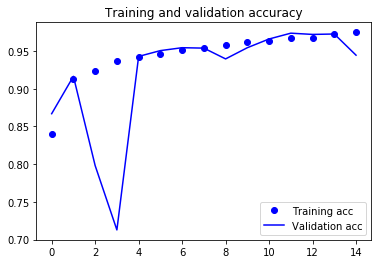

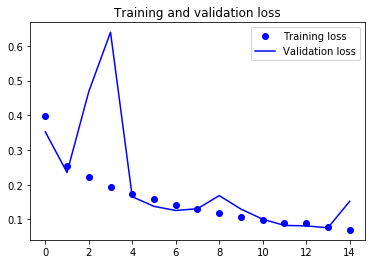

In [5]:
#学習結果を表示
import matplotlib.pyplot as plt

acc = model.history['acc']
val_acc = model.history['val_acc']
loss = model.history['loss']
val_loss = model.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('acc_2.png')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('loss_2.png')


In [6]:
#モデルの保存

json_string = model.model.to_json()
open('./model/d_or_h_predict.json', 'w').write(json_string)

#重みの保存

hdf5_file = "./model/d_or_h_predict.hdf5"
model.model.save_weights(hdf5_file)


In [7]:
from PIL import Image
import os, glob
import numpy as np
import random, math

# 画像が保存されているディレクトリのパス
root_dir = "./img_test"
# 画像が保存されているフォルダ名
categories = ["demon_test","human_test"]

X = [] # 画像データ
Y = [] # ラベルデータ

# フォルダごとに分けられたファイルを収集
#（categoriesのidxと、画像のファイルパスが紐づいたリストを生成）
allfiles = []
for idx, cat in enumerate(categories):
    image_dir = root_dir + "/" + cat
    files = glob.glob(image_dir + "/*.jpeg")
    for f in files:
        allfiles.append((idx, f))

for cat, fname in allfiles:
    img = Image.open(fname)
    img = img.convert("RGB")
    img = img.resize((128,128))
    data = np.asarray(img)
    X.append(data)
    Y.append(cat)

x = np.array(X)
y = np.array(Y)

np.save("./test/d_or_h_data_test_X.npy", x)
np.save("./test/d_or_h_data_test_Y.npy", y)


In [8]:
# モデルの精度を測る
eval_X = np.load("./test/d_or_h_data_test_X.npy")
eval_Y = np.load("./test/d_or_h_data_test_Y.npy")

from keras.utils import np_utils

# データの整数値を2値クラスの行列に変換
eval_Y = np_utils.to_categorical(test_Y, 2)

score = model.model.evaluate(x=test_X, y=test_Y)

print('loss=', score[0])
print('accuracy=', score[1])


NameError: name 'test_Y' is not defined

In [12]:
# モデルの読み込み
model = model_from_json(open('./model/d_or_h_predict.json',"w").read(model.model.to_json()))


NameError: name 'model_from_json' is not defined

In [13]:
from keras.models import Sequential, model_from_json
# モデルの読み込み
model = model_from_json(open('./model/d_or_h_predict.json',"w").read(model.model.to_json()))

NameError: name 'model' is not defined

In [14]:
print(model)


NameError: name 'model' is not defined